### Import modules 

In [20]:
# numpy stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import *
from keras.models import *
from keras import optimizers
from keras.callbacks import *

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from autoencoder_BATADAL import load_AEED

# os and time utils
import os
import time
import glob

import pickle

### Autoencoder classes

In [48]:
# classes
class AutoEncoder(object):
    """ Keras-based AutoEncoder (AE) class used for event detection.

        Attributes:
        params: dictionary with parameters defining the AE structure,
    """
    def __init__(self, **kwargs):
        """ Class constructor, stores parameters and initialize AE Keras model. """
        
        # Default parameters values. If nI is not given, the code will crash later.
        params = {
            'nI': None,
            'nH': 3,
            'cf': 1,
            'activation' : 'tanh',
            'optimizer' : None,
            'verbose' : 0
            }

        for key,item in kwargs.items():
            params[key] = item
        
        self.params = params

    def create_model(self):
        """ Creates Keras AE model.

            The model has nI inputs, nH hidden layers in the encoder (and decoder)
            and cf compression factor. The compression factor is the ratio between
            the number of inputs and the innermost hidden layer which stands between
            the encoder and the decoder. The size of the hidden layers between the 
            input (output) layer and the innermost layer decreases (increase) linearly
            according to the cg.
        """
        
        # retrieve params
        nI = self.params['nI'] # number of inputs
        nH = self.params['nH'] # number of hidden layers in encoder (decoder)
        cf = self.params['cf'] # compression factor
        activation = self.params['activation'] # autoencoder activation function
        optimizer = self.params['optimizer'] # Keras optimizer
        verbose = self.params['verbose'] # echo on screen
        
        # get number/size of hidden layers for encoder and decoder
        temp = np.linspace(nI,nI/cf,nH + 1).astype(int)
        nH_enc = temp[1:]
        nH_dec = temp[:-1][::-1]

        # input layer placeholder
        input_layer = Input(shape=(nI,))

        # build encoder
        for i, layer_size in enumerate(nH_enc):
            if i == 0:
                # first hidden layer
                encoder = Dense(layer_size, activation=activation)(input_layer)
            else:
                # other hidden layers
                encoder = Dense(layer_size, activation=activation)(encoder)

        # build decoder
        for i, layer_size in enumerate(nH_dec):
            if i == 0:
                # first hidden layer
                decoder = Dense(layer_size, activation=activation)(encoder)
            else:
                # other hidden layers
                decoder = Dense(layer_size, activation=activation)(decoder)

        # create autoencoder
        autoencoder = Model(input_layer, decoder)
        if optimizer == None:
            optimizer = optimizers.Adam(lr = 0.001)

        # print autoencoder specs
        if verbose > 0:
            print('Created autoencoder with structure:');
            print(', '.join('layer_{}: {}'.format(v, i) for v, i in enumerate(np.hstack([nI,nH_enc,nH_dec]))))

        # compile and return model
        autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
        autoencoder.summary()
        return autoencoder
    
    def build_predictor(self):
        model = Sequential()
        '''
        model.add(LSTM(43,dropout_U = 0.2, dropout_W = 0.2, input_shape=(2,43)))# return_sequences=True, 
        #model.add(LSTM(43, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(Dense(43, activation = 'relu'))
        '''
        model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape = (1,43), padding='same'))
        model.add(MaxPooling1D(pool_size=1, strides=None))
        model.add(Conv1D(128, 2, activation='relu', padding='same'))
        model.add(MaxPooling1D(pool_size=1))
        model.add(Conv1D(256, 2, activation='relu', padding='same'))
        model.add(MaxPooling1D(pool_size=1))
        model.add(Flatten())
        model.add(Dropout(0.3, noise_shape=None, seed=13))
        model.add(Dense(43, activation='relu'))     
        
        model.compile(loss='mean_squared_error', optimizer=  optimizers.Adam(lr = 0.001))
        model.summary()
        return model

    def train(self, x, y, **train_params):
        """ Train autoencoder,

            x: inputs (inputs == targets, AE are self-supervised ANN).
        """        
        if self.params['verbose']:
            if self.ann == None:
                print('Creating model.')
                self.create_model()
        self.ann.fit(x, y, **train_params)


    def predict(self, x, test_params={}):
        """ Yields reconstruction error for all inputs,

            x: inputs.
        """
        return self.ann.predict(x, **test_params)

class AEED(AutoEncoder):
    """ This class extends the AutoEncoder class to include event detection
        functionalities.
    """
    
    def difference(x):
        return (x[-1] - x[0])**2
    
    def initialize(self):
        """ Create the underlying Keras model. """
        self.ann = self.build_predictor()#create_model()

    def predict(self, x, y, **keras_params):
        """ Predict with autoencoder. """        
        preds = super(AEED, self).predict(x,keras_params)
        errors = pd.DataFrame((y-preds)**2)
        return preds, errors        
        
    def detect(self, x, y, theta, window = 1, average=False, sys_theta = 0, **keras_params):
        """ Detection performed based on (smoothed) reconstruction errors.

            x = inputs,
            theta = threshold, attack flagged if reconstruction error > threshold,
            window = length of the smoothing window (default = 1 timestep, i.e. no smoothing),
            average = boolean (default = False), if True the detection is performed
                on the average reconstruction error across all outputs,
            keras_params = parameters for the Keras-based AE prediction.
        """
        #        preds = super(AEED, self).predict(x,keras_params)
        preds, temp = self.predict(x, y, **keras_params)
        #temp = (x-preds)**2
        if average:
            errors = temp.mean(axis=1).rolling(window=window).mean()             
            detection = errors > theta
        else:
            errors = temp.rolling(window=window).mean()
            detection = errors.apply(lambda x: x>np.max(theta.name, sys_theta)) 
            
        return detection, errors

    def save(self, filename, scaler, theta):
        """ Save AEED modelself.

            AEED parameters saved in a .json, while Keras model is stored in .h5 .
        """
        # parameters
        with open(filename+'.json', 'w') as fp:
            json.dump(self.params, fp)
        # keras model
        self.ann.save(filename+'.h5')
        with open("theta", 'w') as f:
            f.write(str(theta))
        pickle.dump(scaler, open( "scaler.p", "wb" ))
        # echo
        print('Saved AEED parameters to {0}.\nKeras model saved to {1}'.format(filename+'.json', filename+'.h5'))


# functions
def load_AEED(params_filename, model_filename):
    """ Load stored AEED. """
    # load params and create AEED
    with open(params_filename) as fd:
        params = json.load(fd)
    aeed = AEED(**params)

    # load keras model
    aeed.ann = load_model(model_filename)
    return aeed


In [49]:
def create_dataset(dataset, window_size = 4):
    """ 
    Creates the dataset composed by window_size samples of sensor readings and their relative label
    
    if windows size is 2, it returns a dataset composed [[[x-1, x][x]], [[x, x+1][x+1]], ...]
    Parameters
    ----------
    dataset :  list
        list of dataset samples
    window_size : int
        number of samples used for feeding the network.

    Returns
    -------
    np array
        dataset samples organized in groups of windows_size
    np array
        target of model prediction
    """
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size + 1)] #remove +1 to turn into 1-step ahead prediction
        data_X.append(a)
        data_Y.append(dataset[i + window_size])
    return(np.array(data_X), np.array(data_Y))

### Load and preprocess training data

In [50]:
# load training dataset
data_path = "../Data/BATADAL/"
df_train_orig = pd.read_csv(data_path + "train_dataset.csv", parse_dates = ['DATETIME'], dayfirst=True)

In [51]:
# get dates and columns with sensor readings
dates_train = df_train_orig['DATETIME']
sensor_cols = [col for col in df_train_orig.columns if col not in ['Unnamed: 0','DATETIME', 'ATT_FLAG']]

In [52]:
# scale sensor data
scaler = MinMaxScaler()
X =scaler.fit_transform(df_train_orig[sensor_cols])
# split into training and validation
X1, X2, _, _  = train_test_split(X, X, test_size=0.33, random_state=42, shuffle=False)
window = 0
train_X, train_Y = create_dataset(X1, window) #to use also the current reading
test_X, test_Y = create_dataset(X2, window)

### Train autoencoder

In [53]:
# define model parameters
params = {
    'nI' : X.shape[1],
    'nH' : 3,
    'cf' : 2.5,
    'activation' : 'tanh',
    'verbose' : 1,
}

# create AutoEncoder for Event Detection (AEED)
autoencoder = AEED(**params)
autoencoder.initialize()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 1, 64)             5568      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1, 128)            16512     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1, 256)            65792     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 1, 256)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
__________

In [54]:
# train models with early stopping and reduction of learning rate on plateau
earlyStopping= EarlyStopping(monitor='val_loss', patience=3, verbose=0,  min_delta=1e-4, mode='auto')
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, epsilon=1e-4, mode='min')
    
# initialize time
start_time = time.time()

# train autoencoder
autoencoder.train(train_X,train_Y,
            epochs=500,
            batch_size=32,
            shuffle=False,
            callbacks = [earlyStopping, lr_reduced],
            verbose = 2,
            validation_data=(test_X, test_Y))

/home/alessando/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 32230 samples, validate on 15874 samples
Epoch 1/500
 - 4s - loss: 0.0245 - val_loss: 0.0024
Epoch 2/500
 - 3s - loss: 0.0082 - val_loss: 0.0014
Epoch 3/500
 - 3s - loss: 0.0052 - val_loss: 0.0014
Epoch 4/500
 - 3s - loss: 0.0034 - val_loss: 6.3097e-04
Epoch 5/500
 - 3s - loss: 0.0030 - val_loss: 6.5605e-04
Epoch 6/500
 - 3s - loss: 0.0025 - val_loss: 5.0020e-04
Epoch 7/500
 - 4s - loss: 0.0023 - val_loss: 4.6645e-04
Epoch 8/500
 - 3s - loss: 0.0021 - val_loss: 4.4182e-04
Epoch 9/500
 - 4s - loss: 0.0020 - val_loss: 4.5075e-04


### Test autoencoder

In [55]:
def compute_scores(Y,Yhat):
    fpr, recall, _ = roc_curve(Y, Yhat)
    return [accuracy_score(Y,Yhat),f1_score(Y,Yhat),precision_score(Y,Yhat),recall[1], fpr[1]]

In [56]:
# Load dataset with attacks
df_test_01 = pd.read_csv(data_path + 'test_dataset_1.csv')#, parse_dates = ['DATETIME'], dayfirst=True)
df_test_02 = pd.read_csv(data_path + "test_dataset_2.csv")#, parse_dates = ['DATETIME'], dayfirst=True)


# scale datasets
X3 = pd.DataFrame(index = df_test_01.index, columns = sensor_cols, 
                  data = scaler.transform(df_test_01[sensor_cols]))

X4 = pd.DataFrame(index = df_test_02.index, columns = sensor_cols, 
                  data = scaler.transform(df_test_02[sensor_cols]))

X3, Y3_target = create_dataset(X3.values, window) #to use also the current reading
X4, Y4_target = create_dataset(X4.values, window)

# get targets
Y3 = df_test_01['ATT_FLAG']
Y4 = df_test_02['ATT_FLAG']

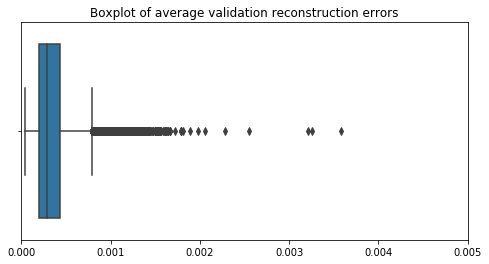

In [57]:
# perform detection

# get validation reconstruction errors
_, validation_errors = autoencoder.predict(test_X, test_Y)


# plot distribution of average validation reconstruction errors 
f, ax = plt.subplots(1, figsize = (8,4))
sns.boxplot(validation_errors.mean(axis=1), ax=ax)
ax.set_xlim([0,0.005])
ax.set_title('Boxplot of average validation reconstruction errors')

# set treshold as quantile of average reconstruction error
theta = validation_errors.mean(axis = 1).quantile(0.995)

Yhat3, _ = autoencoder.detect(X3, Y3_target, theta = theta , window = 3, average=True)
Yhat4, _ = autoencoder.detect(X4, Y4_target, theta = theta, window = 3, average=True)

In [59]:
results = pd.DataFrame(index = ['test dataset 01','test dataset 02'], 
                       columns = ['accuracy','f1_score','precision','recall','fpr'])
results.loc['test dataset 01'] = compute_scores(Y3[:-1],Yhat3)
results.loc['test dataset 02'] = compute_scores(Y4[:-1],Yhat4)


print('Results:\n')
print(results)
results.mean()

Results:

                 accuracy  f1_score precision    recall         fpr
test dataset 01  0.951009  0.740741  0.851485  0.655488   0.0136662
test dataset 02  0.932143  0.748899  0.930657  0.626536  0.00899195


accuracy     0.941576
f1_score     0.744820
precision    0.891071
recall       0.641012
fpr          0.011329
dtype: float64

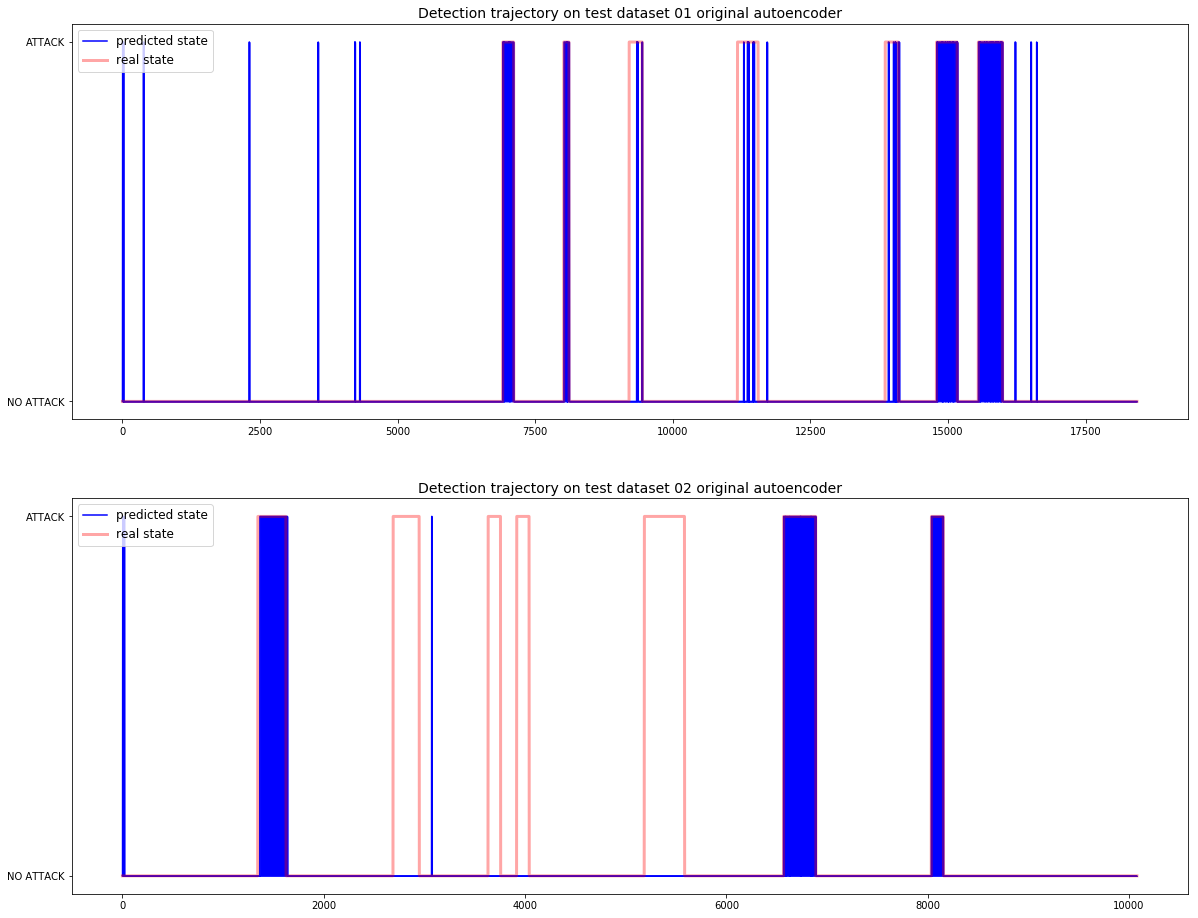

In [38]:
# plot figure
shade_of_gray = '0.75'
f, axes = plt.subplots(2,figsize = (20,16))
axes[0].plot(Yhat3, color = 'b', label = 'predicted state')
axes[0].fill_between(Yhat3.index, Yhat3.values, where=Yhat3.values <=1, interpolate=True, color='b')
axes[0].plot(Y3, color = 'r', alpha = 0.35, lw = 3, label = 'real state')
axes[0].set_title('Detection trajectory on test dataset 01 original autoencoder', fontsize = 14)
axes[0].set_yticks([0,1])
axes[0].set_yticklabels(['NO ATTACK','ATTACK'])
axes[0].legend(fontsize = 12, loc = 2)

axes[1].plot(Yhat4, color = 'b', label = 'predicted state')
axes[1].fill_between(Yhat4.index, Yhat4.values, where=Yhat4.values <=1, interpolate=True, color='b')
axes[1].plot(Y4, color = 'r', alpha = 0.35, lw = 3, label = 'real state')
axes[1].set_title('Detection trajectory on test dataset 02 original autoencoder', fontsize = 14)
axes[1].set_yticks([0,1])
axes[1].set_yticklabels(['NO ATTACK','ATTACK'])
axes[1].legend(fontsize = 12, loc = 2)

#plt.savefig('saves/original-substitute-detection.png', format='png')

In [85]:
# save autoencoder
autoencoder.save('LSTM', scaler, theta)

Saved AEED parameters to LSTM.json.
Keras model saved to LSTM.h5
